In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 加载数据
csv_file_path = 'snr_data/output_data_snr_6.csv'
data_frame = pd.read_csv(csv_file_path)

# 提取 I 和 Q 分量
I_components = data_frame.iloc[:, :128].values
Q_components = data_frame.iloc[:, 128:256].values

# 将 I 和 Q 分量堆叠
stacked_components = np.stack((I_components, Q_components), axis=1)

# 转换为torch张量
vectors = torch.tensor(stacked_components, dtype=torch.float32)  # 形状为 [n_samples, 2, 128]

# 归一化处理
train_size = int(0.8 * len(vectors))
train_vectors = vectors[:train_size]
train_mean = train_vectors.mean(dim=0, keepdim=True)
train_std = train_vectors.std(dim=0, keepdim=True)
vectors = (vectors - train_mean) / train_std

print(vectors.shape)  # 输出形状应该是 [n_samples, 2, 128]

# 提取Mod_Type列并转换为数值标签
mod_types = data_frame['Mod_Type'].astype('category').cat.codes.values
labels = torch.tensor(mod_types, dtype=torch.long)

# 创建TensorDataset
dataset = TensorDataset(vectors, labels)
train_dataset, test_dataset = random_split(dataset, [train_size, len(vectors) - train_size])

# 创建DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([11000, 2, 128])


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, num_classes):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(128, input_dim)  # 确保这里从128维映射到input_dim
        encoder_layers = TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.transformer_encoder = TransformerEncoder(encoder_layer=encoder_layers, num_layers=num_layers)
        self.fc_out = nn.Linear(input_dim, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # Rearrange input to seq_length, batch_size, features
        
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # Aggregate over the sequence
        x = self.dropout(x)
        x = self.fc_out(x)
        return x


# Model instantiation
model = SimpleTransformer(input_dim=16, num_heads=4, num_layers=2, num_classes=11)


In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


In [4]:
num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # 测试阶段
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

print("Training complete.")


Epoch [1/50], Train Loss: 2.0477, Train Accuracy: 0.1932, Test Loss: 1.8577, Test Accuracy: 0.2482
Epoch [2/50], Train Loss: 1.7863, Train Accuracy: 0.2686, Test Loss: 1.6271, Test Accuracy: 0.3282
Epoch [3/50], Train Loss: 1.5837, Train Accuracy: 0.3522, Test Loss: 1.4440, Test Accuracy: 0.4032
Epoch [4/50], Train Loss: 1.4284, Train Accuracy: 0.4049, Test Loss: 1.3068, Test Accuracy: 0.4268
Epoch [5/50], Train Loss: 1.3448, Train Accuracy: 0.4198, Test Loss: 1.3160, Test Accuracy: 0.4423
Epoch [6/50], Train Loss: 1.2984, Train Accuracy: 0.4484, Test Loss: 1.3159, Test Accuracy: 0.4432
Epoch [7/50], Train Loss: 1.2729, Train Accuracy: 0.4497, Test Loss: 1.2562, Test Accuracy: 0.4318
Epoch [8/50], Train Loss: 1.2439, Train Accuracy: 0.4605, Test Loss: 1.2210, Test Accuracy: 0.4768
Epoch [9/50], Train Loss: 1.2377, Train Accuracy: 0.4677, Test Loss: 1.2098, Test Accuracy: 0.4936
Epoch [10/50], Train Loss: 1.1841, Train Accuracy: 0.4853, Test Loss: 1.1967, Test Accuracy: 0.4964
Epoch [11

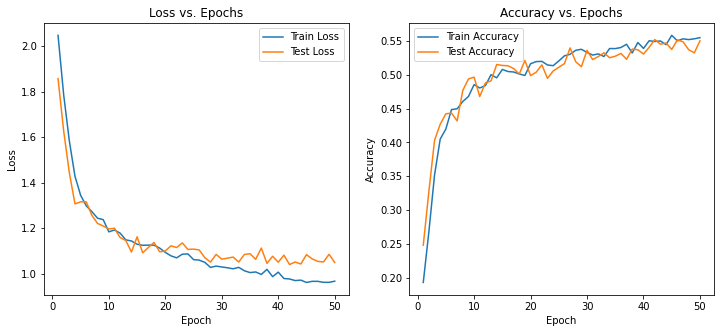

In [5]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# 绘制损失图像
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

# 绘制准确率图像
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.show()


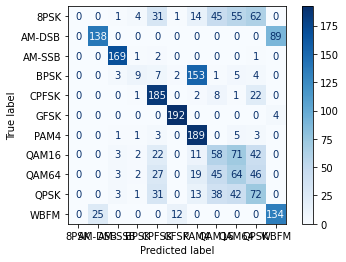

In [6]:
# 计算混淆矩阵
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# 绘制混淆矩阵
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_frame['Mod_Type'].astype('category').cat.categories)
disp.plot(cmap=plt.cm.Blues)
plt.show()
